## Libraries

In [111]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import plotly.express as px
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from neo4j import GraphDatabase
from pm4py.objects.log.obj import EventLog, Trace
import pm4py
import numpy as np
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Connect to Neo4J database

In [112]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("Username", "Password"))
session = driver.session()

## Retrieve data 

In [113]:
query = f'''MATCH (e:Event) - [:CORR] -> (n:Run {{EntityType: "Kit"}})
where n.durationInMinutes > 0
Optional match (e) - [:WASHED_IN] -> (w:WashingMachine)
Optional match (e) - [:WASHED_ON] -> (r:Rack)
Optional match (e) - [:STERILIZED_IN] -> (s:SterilizationMachine)
RETURN e.CaseID, e.KitID, n.startTimestamp, n.endTimestamp, e.Activity, e.Usuario, e.timestamp, w.machine, r.name, s.machine, s.type, e.batchID'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()

,e.CaseID,e.KitID,n.startTimestamp,n.endTimestamp,e.Activity,e.Usuario,e.timestamp,w.machine,r.name,s.machine,s.type,e.batchID
0,EQP-QUI.ORL.OPT-14-CN35128,EQP-QUI.ORL.OPT-14,2022-03-31T10:50:00.000000000+00:00,2022-03-31T14:26:00.000000000+00:00,Carga L+D liberada,MCE,2022-03-31 12:04:00+00:00,None,None,None,None,b60282
1,EQP-QUI.ORL.OPT-14-CN35128,EQP-QUI.ORL.OPT-14,2022-03-31T10:50:00.000000000+00:00,2022-03-31T14:26:00.000000000+00:00,Carga L+D iniciada,BM,2022-03-31 11:02:00+00:00,None,None,None,None,b44646
2,EQP-QUI.ORL.OPT-14-CN35128,EQP-QUI.ORL.OPT-14,2022-03-31T10:50:00.000000000+00:00,2022-03-31T14:26:00.000000000+00:00,Composición de cargas,EH,2022-03-31 12:41:00+00:00,None,None,Autoclave 1,High Temperature Sterilization,b137103
3,EQP-QUI.ORL.OPT-14-CN35128,EQP-QUI.ORL.OPT-14,2022-03-31T10:50:00.000000000+00:00,2022-03-31T14:26:00.000000000+00:00,Montaje,PN,2022-03-31 12:19:00+00:00,None,None,None,None,b99106
4,EQP-QUI.ORL.OPT-14-CN35128,EQP-QUI.ORL.OPT-14,2022-03-31T10:50:00.000000000+00:00,2022-03-31T14:26:00.000000000+00:00,Producción montada,PN,2022-03-31 12:20:00+00:00,None,None,None,None,b99105


In [114]:
df.describe()

,e.CaseID,e.KitID,n.startTimestamp,n.endTimestamp,e.Activity,e.Usuario,e.timestamp,w.machine,r.name,s.machine,s.type,e.batchID
count,214153,214153,214153,214153,214153,214153,214153,14780,17213,14263,14263,214153
unique,20502,2039,5501,2415,9,20,29006,8,15,6,2,39997
top,EXT-HOS.008-0-CN13125,EXT-HOS.007-0,2022-01-19T07:43:00.000000000+00:00,2022-02-16T18:08:00.000000000+00:00,Producción montada,ER,2022-03-04 17:03:00+00:00,Lavadora 2,Rack-Lav. 06,Autoclave 2,High Temperature Sterilization,b186942
freq,285,7773,450,949,37874,19077,215,4068,1977,4060,13768,237
first,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 07:09:00+00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-31 21:54:00+00:00,NaN,NaN,NaN,NaN,NaN


In [115]:
event_log = pm4py.format_dataframe(df, case_id='e.CaseID', activity_key='e.Activity', timestamp_key='e.timestamp')
#event_log = pm4py.convert_to_event_log(event_log)
event_log

,case:concept:name,e.KitID,n.startTimestamp,n.endTimestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,e.batchID,@@index
170521,012047 L2901-0-CN10738,012047 L2901-0,2022-01-26T17:31:00.000000000+00:00,2022-01-28T08:16:00.000000000+00:00,Montaje,CM,2022-01-26 17:31:00+00:00,None,None,None,None,b92692,170521
170520,012047 L2901-0-CN10738,012047 L2901-0,2022-01-26T17:31:00.000000000+00:00,2022-01-28T08:16:00.000000000+00:00,Montaje,SM,2022-01-28 08:16:00+00:00,None,None,None,None,b92289,170520
195895,012047 L2901-0-CN1080,012047 L2901-0,2022-01-04T16:00:00.000000000+00:00,2022-01-07T13:06:00.000000000+00:00,Montaje,CM,2022-01-04 16:00:00+00:00,None,None,None,None,b97843,195895
195894,012047 L2901-0-CN1080,012047 L2901-0,2022-01-04T16:00:00.000000000+00:00,2022-01-07T13:06:00.000000000+00:00,Montaje,CM,2022-01-05 14:04:00+00:00,None,None,None,None,b97713,195894
195896,012047 L2901-0-CN1080,012047 L2901-0,2022-01-04T16:00:00.000000000+00:00,2022-01-07T13:06:00.000000000+00:00,Producción montada,CM,2022-01-05 14:04:00+00:00,None,None,None,None,b97713,195896
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186011,TRAN-QUI.TRA.ZIMMER-2-CN5129,TRAN-QUI.TRA.ZIMMER-2,2022-01-14T13:04:00.000000000+00:00,2022-01-14T21:12:00.000000000+00:00,Comisionado,MMF,2022-01-14 21:12:00+00:00,None,None,None,None,b229711,186011
14007,TRAN-QUI.TRA.ZIMMER-6-CN28683,TRAN-QUI.TRA.ZIMMER-6,2022-03-07T13:53:00.000000000+00:00,2022-03-08T17:55:00.000000000+00:00,Montaje,BM,2022-03-08 14:30:00+00:00,None,None,None,None,b82260,14007
14010,TRAN-QUI.TRA.ZIMMER-6-CN28683,TRAN-QUI.TRA.ZIMMER-6,2022-03-07T13:53:00.000000000+00:00,2022-03-08T17:55:00.000000000+00:00,Producción montada,BM,2022-03-08 14:30:00+00:00,None,None,None,None,b110167,14010
14008,TRAN-QUI.TRA.ZIMMER-6-CN28683,TRAN-QUI.TRA.ZIMMER-6,2022-03-07T13:53:00.000000000+00:00,2022-03-08T17:55:00.000000000+00:00,Composición de cargas,PN,2022-03-08 16:09:00+00:00,None,None,None,None,b147920,14008


In [116]:
original_df = event_log.copy()
original_df.fillna('NaN', inplace=True)

In [117]:
event_log = pm4py.convert_to_event_log(event_log)

## Split train test


In [118]:
prefix_traces = []
for trace in event_log:
    trace_end_flag = False
    for i,event in enumerate(trace):
        if "Comisionado" in event['concept:name']:
            trace_end_flag = True
            i+=1
            break
        if "Carga de esterilizador liberada" in event['concept:name']:
            trace_end_flag = True
    if trace_end_flag:
        prefix_traces.append(Trace(trace[:i], attributes = trace.attributes))
prefix_traces = EventLog(prefix_traces)

In [119]:
trace = pm4py.convert_to_dataframe(prefix_traces)
trace.head()


,e.KitID,n.startTimestamp,n.endTimestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,e.batchID,@@index,case:concept:name
0,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Montaje,CM,2022-01-13 20:35:00+00:00,None,None,None,None,b95841,186149,012047 L2901-0-CN4835
1,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Producción montada,CM,2022-01-13 20:35:00+00:00,None,None,None,None,b95841,186150,012047 L2901-0-CN4835
2,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Composición de cargas,ML,2022-01-14 14:57:00+00:00,None,None,None,None,b169827,186148,012047 L2901-0-CN4835
3,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Carga de esterilizador liberada,ML,2022-01-14 16:23:00+00:00,None,None,None,None,b207122,186146,012047 L2901-0-CN4835
4,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Entrada Material Sucio,EH,2022-01-12 09:04:00+00:00,None,None,None,None,b27460,71023,DEP-QUI.BTF-1-CN3765


In [120]:
# get completion time and sort
completion_time_ls = list(trace.groupby(['case:concept:name'])['time:timestamp'].max())
completion_time_ls = sorted(completion_time_ls)

In [121]:
# split on 70% max time 
train_split_portion = 0.70
val_split_seperation = 0.85
total_data = len(completion_time_ls)
train_len = int(train_split_portion*total_data)
val_len = int(val_split_seperation*total_data)
last_train_completion_time = completion_time_ls[train_len]
last_val_completion_time = completion_time_ls[val_len]
val_start_time = last_train_completion_time
last_train_completion_time,last_val_completion_time

(Timestamp('2022-03-07 21:42:00+0000', tz='UTC'),
 Timestamp('2022-03-20 19:35:00+0000', tz='UTC'))

In [122]:
# take all traces where start dates are after the last_train_completion_time
dtype_list = list(trace.dtypes) # get original types of the columns
train_df = pd.DataFrame(columns = trace.columns)
test_df = pd.DataFrame(columns = trace.columns)
val_df = pd.DataFrame(columns = trace.columns)
train_count,test_count,val_count = 0,0,0
intersecting_traces = []
for name, group in trace.groupby(['case:concept:name'],as_index=False):
    if group['time:timestamp'].iloc[-1] <= last_train_completion_time:
        train_df = train_df.append(group)
        train_count+=1
    # elif (group['startTime'].iloc[0] >= last_train_completion_time) and (group['completeTime'].iloc[-1] <= last_val_completion_time):
    elif group['time:timestamp'].iloc[-1] <= last_val_completion_time:
        val_df = val_df.append(group)
        val_count+=1        
    # elif group['startTime'].iloc[0] >= last_val_completion_time:
    #     test_df = test_df.append(group)
    #     test_count+=1
    else:
        test_df = test_df.append(group)
        test_count+=1
        # intersecting_traces.append(group)


# converting train and test to their original data types
for i,col in enumerate(train_df.columns):
    train_df[col] = train_df[col].astype(dtype_list[i])

for i,col in enumerate(test_df.columns):
    test_df[col] = test_df[col].astype(dtype_list[i])

for i,col in enumerate(val_df.columns):
    val_df[col] = val_df[col].astype(dtype_list[i])


print("train, val and test count")
print(train_count,val_count,test_count)

train, val and test count
12754 2728 2732


## Data encoding

In [123]:
def get_ohe_dict(categorical_vars, df):
    ohe_dict = {}
    for var in categorical_vars:
        var_dict = {}
        print(df[var].unique())
        var_data = sorted(df[var].unique())
        var_len = len(var_data)
        for i,cat in enumerate(var_data):
            var_dict[cat] = [0]*var_len
            var_dict[cat][i] = 1

        ohe_dict[var] = var_dict

    return ohe_dict

In [124]:
# function to save the data
def save_data(X,y,feature_names, save_path):
    data_dict = {}
    data_dict['X'] = X
    data_dict['y'] = y
    data_dict['feature_names'] = feature_names

    # save pickle
    with open(save_path, 'wb') as handle:
        pickle.dump(data_dict, handle)

In [125]:
def load_data(load_path):
    with open(load_path, 'rb') as handle:
        data = pickle.load(handle)
    return data

### Train data

In [126]:
t_length = 10
save_path_base = '/Users/abdalrhman/Documents/bdma-thesis/python/data/'
df_type = 'train'
permits = train_df

In [127]:
trace_log = pm4py.format_dataframe(permits, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
trace_log = pm4py.convert_to_event_log(trace_log)

In [128]:
is_delayed = []
for trace in trace_log:
    flag = False
    for i,event in enumerate(trace):
        if (not event['n.startTimestamp'] and not event['n.endTimestamp']):
            continue
        startTimestamp = pd.to_datetime(event['n.startTimestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
        finishTimestamp = pd.to_datetime(event['n.endTimestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')

        duration_minutes = (finishTimestamp - startTimestamp).total_seconds() / 60

        if duration_minutes > 370:
            flag = True
            break
    
    if flag:
        is_delayed.append(1)
    else:
        is_delayed.append(0)

In [129]:
prefix_traces = []
for trace in trace_log:
    for i,event in enumerate(trace):
        if ("Comisionado" not in event['concept:name']) or ("Carga de esterilizador liberada" not in event['concept:name']):
            break
    prefix_traces.append(Trace(trace[:i], attributes = trace.attributes))
prefix_traces = EventLog(prefix_traces)

In [130]:
trace_prefixes = EventLog([Trace(trace[0:t_length], attributes = trace.attributes) for trace in prefix_traces])

In [131]:
df = pm4py.convert_to_dataframe(trace_log)
df.head(5)

,e.KitID,n.startTimestamp,n.endTimestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,e.batchID,@@index,case:concept:name
0,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Montaje,CM,2022-01-13 20:35:00+00:00,None,None,None,None,b95841,0,012047 L2901-0-CN4835
1,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Producción montada,CM,2022-01-13 20:35:00+00:00,None,None,None,None,b95841,1,012047 L2901-0-CN4835
2,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Composición de cargas,ML,2022-01-14 14:57:00+00:00,None,None,None,None,b169827,2,012047 L2901-0-CN4835
3,012047 L2901-0,2022-01-13T20:35:00.000000000+00:00,2022-01-14T17:47:00.000000000+00:00,Carga de esterilizador liberada,ML,2022-01-14 16:23:00+00:00,None,None,None,None,b207122,3,012047 L2901-0-CN4835
4,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Entrada Material Sucio,EH,2022-01-12 09:04:00+00:00,None,None,None,None,b27460,4,DEP-QUI.BTF-1-CN3765


In [132]:
cases = list(df.groupby(['case:concept:name'],sort=False)['e.KitID'].first().keys())
df_dict = dict()
df_dict['case:concept:name'] = cases
df_dict['is_delayed'] = is_delayed
temp_df = pd.DataFrame(df_dict)

# merge target variable with permits
df = df.merge(temp_df,on=['case:concept:name'])
df.drop(columns=['n.endTimestamp', 'time:timestamp', '@@index', 'n.startTimestamp'], inplace=True)
df.head()

,e.KitID,concept:name,e.Usuario,w.machine,r.name,s.machine,s.type,e.batchID,case:concept:name,is_delayed
0,012047 L2901-0,Montaje,CM,None,None,None,None,b95841,012047 L2901-0-CN4835,1
1,012047 L2901-0,Producción montada,CM,None,None,None,None,b95841,012047 L2901-0-CN4835,1
2,012047 L2901-0,Composición de cargas,ML,None,None,None,None,b169827,012047 L2901-0-CN4835,1
3,012047 L2901-0,Carga de esterilizador liberada,ML,None,None,None,None,b207122,012047 L2901-0-CN4835,1
4,DEP-QUI.BTF-1,Entrada Material Sucio,EH,None,None,None,None,b27460,DEP-QUI.BTF-1-CN3765,1


In [133]:
save_path = save_path_base + df_type +'_trace_len_'+str(t_length)+ '.csv'
df.to_csv(save_path,index=False)

In [134]:
str_ev_attr = ['concept:name', 'e.Usuario', 'w.machine', 'r.name', 's.machine',	's.type']
str_tr_attr = ['e.KitID']
categorical_vars = str_ev_attr + str_tr_attr
ohe_dict = get_ohe_dict(categorical_vars, original_df)
categorical_vars

['Montaje' 'Producción montada' 'Carga L+D iniciada' 'Carga L+D liberada'
 'Composición de cargas' 'Carga de esterilizador liberada'
 'Entrada Material Sucio' 'Cargado en carro L+D' 'Comisionado']
['CM' 'SM' 'BM' 'ML' 'AV' 'MCE' 'LI' 'ER' 'PN' 'EH' 'MR' 'PG' 'CLE' 'VA'
 'SP' 'VS' 'MMF' 'MAA' 'DF' 'MGP']
['NaN' 'Lavadora 3' 'Lavadora 1' 'Lavadora 2' 'Lavadora 4' 'Jupiter'
 'Esclusa Lavado' 'Esclusa Reposicion' 'Esclusa Caducado']
['NaN' 'Rack-Lav. 03' 'Rack-Lav. 05' 'Rack-Lav. 04' 'Rack-Lav. 01'
 'Rack-Lav. 10' 'Rack-Lav. 06' 'Rack-Lav. 09' 'Rack-Lav. 02'
 'Rack-Lav. 07' 'Rack-Lav. 08' 'Esclusa 01' 'Rack-Jupiter 02'
 'Rack-Jupiter 01' 'Esclusa 02' 'Esclusa 03']
['NaN' 'Autoclave 1' 'Autoclave 4' 'Autoclave 2' 'Autoclave 3'
 'Amsco Vpro' 'Amsco Eagle']
['NaN' 'High Temperature Sterilization' 'Low Temperature Sterilization']
['012047 L2901-0' 'CONT-CCEE.ALE-1' 'CONT-CCEE.CG-1' ...
 'TRAN-QUI.TRA.ZIMMER-1' 'TRAN-QUI.TRA.ZIMMER-2' 'TRAN-QUI.TRA.ZIMMER-6']


['concept:name',
 'e.Usuario',
 'w.machine',
 'r.name',
 's.machine',
 's.type',
 'e.KitID']

In [135]:
data = []

for id, group in df.groupby(['case:concept:name']):
    feature_vec = []

    # add categorical and numerical event attributes
    for cat_atr in str_ev_attr[:1]:
        attr_length = len(list(ohe_dict[cat_atr].values())[0])
        str_ev_vec = np.array([0]*attr_length)

        for ca in group[cat_atr]:
            str_ev_vec  = str_ev_vec + np.array(ohe_dict[cat_atr][ca])

        feature_vec.extend(list(str_ev_vec))

    data.append(feature_vec)

In [136]:
encode_name = 'frequency_encode_'
save_path = save_path_base + encode_name + df_type +'_trace_len_'+str(t_length)+ '.pickle'
save_data(data, is_delayed, ohe_dict ,save_path)

### Test data

In [137]:
df_type = 'test'
permits = test_df

In [138]:
test_df.head()

,e.KitID,n.startTimestamp,n.endTimestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,e.batchID,@@index,case:concept:name
77,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Entrada Material Sucio,MMF,2022-03-30 15:41:00+00:00,None,None,None,None,b18095,2992,DEP-QUI.CPL.SYNTHES-1-CN34976
78,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Cargado en carro L+D,MMF,2022-03-30 16:02:00+00:00,None,None,None,None,b28772,2995,DEP-QUI.CPL.SYNTHES-1-CN34976
79,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Carga L+D iniciada,PG,2022-03-30 16:37:00+00:00,None,Rack-Lav. 06,None,None,b44745,2991,DEP-QUI.CPL.SYNTHES-1-CN34976
80,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Carga L+D liberada,SP,2022-03-30 17:50:00+00:00,None,None,None,None,b60371,2994,DEP-QUI.CPL.SYNTHES-1-CN34976
81,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Montaje,EH,2022-03-30 17:55:00+00:00,None,None,None,None,b75401,2990,DEP-QUI.CPL.SYNTHES-1-CN34976


In [139]:
event_log = pm4py.format_dataframe(permits, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
event_log = pm4py.convert_to_event_log(event_log)
event_log

[{'attributes': {'concept:name': 'DEP-QUI.CPL.SYNTHES-1-CN34976'}, 'events': [{'e.KitID': 'DEP-QUI.CPL.SYNTHES-1', 'n.startTimestamp': neo4j.time.DateTime(2022, 3, 30, 15, 41, 0, 0, tzinfo=<UTC>), 'n.endTimestamp': neo4j.time.DateTime(2022, 3, 30, 20, 37, 0, 0, tzinfo=<UTC>), 'concept:name': 'Entrada Material Sucio', 'e.Usuario': 'MMF', 'time:timestamp': Timestamp('2022-03-30 15:41:00+0000', tz='UTC'), 'w.machine': None, 'r.name': None, 's.machine': None, 's.type': None, 'e.batchID': 'b18095', '@@index': 77}, '..', {'e.KitID': 'DEP-QUI.CPL.SYNTHES-1', 'n.startTimestamp': neo4j.time.DateTime(2022, 3, 30, 15, 41, 0, 0, tzinfo=<UTC>), 'n.endTimestamp': neo4j.time.DateTime(2022, 3, 30, 20, 37, 0, 0, tzinfo=<UTC>), 'concept:name': 'Composición de cargas', 'e.Usuario': 'PN', 'time:timestamp': Timestamp('2022-03-30 18:11:00+0000', tz='UTC'), 'w.machine': None, 'r.name': None, 's.machine': None, 's.type': None, 'e.batchID': 'b137352', '@@index': 83}]}, '....', {'attributes': {'concept:name': '

In [140]:
is_delayed = []
for trace in event_log:
    flag = False
    for i,event in enumerate(trace):
        if (not event['n.startTimestamp'] and not event['n.endTimestamp']):
            continue
        startTimestamp = pd.to_datetime(event['n.startTimestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
        finishTimestamp = pd.to_datetime(event['n.endTimestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')

        duration_minutes = (finishTimestamp - startTimestamp).total_seconds() / 60

        if duration_minutes > 370:
            flag = True
            break
    
    if flag:
        is_delayed.append(1)
    else:
        is_delayed.append(0)

In [141]:
prefix_traces = []
for trace in event_log:
    for i,event in enumerate(trace):
        if ("Comisionado" not in event['concept:name']) or ("Carga de esterilizador liberada" not in event['concept:name']):
            break
    prefix_traces.append(Trace(trace[:i], attributes = trace.attributes))
prefix_traces = EventLog(prefix_traces)

In [142]:
trace_prefixes = EventLog([Trace(trace[0:t_length], attributes = trace.attributes) for trace in prefix_traces])

In [143]:
df = pm4py.convert_to_dataframe(event_log)
df.head(5)

,e.KitID,n.startTimestamp,n.endTimestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,e.batchID,@@index,case:concept:name
0,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Entrada Material Sucio,MMF,2022-03-30 15:41:00+00:00,None,None,None,None,b18095,77,DEP-QUI.CPL.SYNTHES-1-CN34976
1,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Cargado en carro L+D,MMF,2022-03-30 16:02:00+00:00,None,None,None,None,b28772,78,DEP-QUI.CPL.SYNTHES-1-CN34976
2,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Carga L+D iniciada,PG,2022-03-30 16:37:00+00:00,None,Rack-Lav. 06,None,None,b44745,79,DEP-QUI.CPL.SYNTHES-1-CN34976
3,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Carga L+D liberada,SP,2022-03-30 17:50:00+00:00,None,None,None,None,b60371,80,DEP-QUI.CPL.SYNTHES-1-CN34976
4,DEP-QUI.CPL.SYNTHES-1,2022-03-30T15:41:00.000000000+00:00,2022-03-30T20:37:00.000000000+00:00,Montaje,EH,2022-03-30 17:55:00+00:00,None,None,None,None,b75401,81,DEP-QUI.CPL.SYNTHES-1-CN34976


In [144]:
cases = list(df.groupby(['case:concept:name'],sort=False)['e.KitID'].first().keys())
df_dict = dict()
df_dict['case:concept:name'] = cases
df_dict['is_delayed'] = is_delayed
temp_df = pd.DataFrame(df_dict)
df.drop(columns=['n.endTimestamp', 'time:timestamp', '@@index', 'n.startTimestamp'], inplace=True)

# merge target variable with permits
df = df.merge(temp_df,on=['case:concept:name'])
df.head()

,e.KitID,concept:name,e.Usuario,w.machine,r.name,s.machine,s.type,e.batchID,case:concept:name,is_delayed
0,DEP-QUI.CPL.SYNTHES-1,Entrada Material Sucio,MMF,None,None,None,None,b18095,DEP-QUI.CPL.SYNTHES-1-CN34976,0
1,DEP-QUI.CPL.SYNTHES-1,Cargado en carro L+D,MMF,None,None,None,None,b28772,DEP-QUI.CPL.SYNTHES-1-CN34976,0
2,DEP-QUI.CPL.SYNTHES-1,Carga L+D iniciada,PG,None,Rack-Lav. 06,None,None,b44745,DEP-QUI.CPL.SYNTHES-1-CN34976,0
3,DEP-QUI.CPL.SYNTHES-1,Carga L+D liberada,SP,None,None,None,None,b60371,DEP-QUI.CPL.SYNTHES-1-CN34976,0
4,DEP-QUI.CPL.SYNTHES-1,Montaje,EH,None,None,None,None,b75401,DEP-QUI.CPL.SYNTHES-1-CN34976,0


In [145]:
save_path = save_path_base + df_type +'_trace_len_'+str(t_length)+ '.csv'
df.to_csv(save_path,index=False)

In [146]:
encode_name = 'frequency_encode_'
save_path = save_path_base + encode_name + 'train' +'_trace_len_'+str(t_length)+ '.pickle'
loaded_data = load_data(save_path)
ohe_dict = loaded_data['feature_names']

In [147]:
data = []

for id, group in df.groupby(['case:concept:name']):
    feature_vec = []

    # add categorical and numerical event attributes
    for cat_atr in str_ev_attr[:1]:
        attr_length = len(list(ohe_dict[cat_atr].values())[0])
        str_ev_vec = np.array([0]*attr_length)

        for ca in group[cat_atr]:
            str_ev_vec  = str_ev_vec + np.array(ohe_dict[cat_atr][ca])

        feature_vec.extend(list(str_ev_vec))

    data.append(feature_vec)

In [148]:
encode_name = 'frequency_encode_'
save_path = save_path_base + encode_name + df_type +'_trace_len_'+str(t_length)+ '.pickle'
save_data(data, is_delayed, ohe_dict ,save_path)

## Modeling

In [149]:
data_test = load_data(save_path_base + "frequency_encode_test_trace_len_10.pickle")
data_train = load_data(save_path_base + "frequency_encode_train_trace_len_10.pickle")

In [150]:
X_train = np.array(data_train['X'])
X_test = np.array(data_test['X'])
y_train = np.array(data_train['y'])
y_test = np.array(data_test['y'])

In [151]:
results_df = pd.DataFrame(index=['Decision Tree (Default)'],
                          columns=['F-score', 'Precision','Recall', 'Accuracy'])

In [152]:
len(y_test)

2732

In [153]:
# Create Decision Tree classifier object
dt = DecisionTreeClassifier()

# Train Decision Tree Classifier
dt_fit = dt.fit(X_train,y_train)

#Predict the response for test dataset
dt_predict = dt_fit.predict(X_test)

results_df.loc['Decision Tree (Default)',:] = [f1_score(y_test,dt_predict, average='macro'), precision_score(y_test,dt_predict), recall_score(y_test,dt_predict),accuracy_score(y_test,dt_predict)]

results_df.sort_values(by='F-score', ascending=False)

,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.578521,0.635294,0.209845,0.742679


[Text(0.5464320847341075, 0.9761904761904762, 'x[3] <= 0.5\ngini = 0.5\nsamples = 12754\nvalue = [6516, 6238]'),
 Text(0.28639545767114916, 0.9285714285714286, 'x[7] <= 1.5\ngini = 0.407\nsamples = 5706\nvalue = [4085, 1621]'),
 Text(0.1837799893031785, 0.8809523809523809, 'x[6] <= 0.5\ngini = 0.339\nsamples = 4573\nvalue = [3585, 988]'),
 Text(0.14751107885085574, 0.8333333333333334, 'x[5] <= 9.5\ngini = 0.334\nsamples = 4516\nvalue = [3560, 956]'),
 Text(0.11042558068459658, 0.7857142857142857, 'x[8] <= 1.5\ngini = 0.33\nsamples = 4449\nvalue = [3520, 929]'),
 Text(0.06525061124694377, 0.7380952380952381, 'x[5] <= 1.5\ngini = 0.349\nsamples = 3126\nvalue = [2423, 703]'),
 Text(0.03942542787286064, 0.6904761904761905, 'x[5] <= 0.5\ngini = 0.342\nsamples = 3068\nvalue = [2396, 672]'),
 Text(0.017726161369193152, 0.6428571428571429, 'x[0] <= 0.5\ngini = 0.203\nsamples = 227\nvalue = [201, 26]'),
 Text(0.004889975550122249, 0.5952380952380952, 'x[4] <= 0.5\ngini = 0.048\nsamples = 121\nv

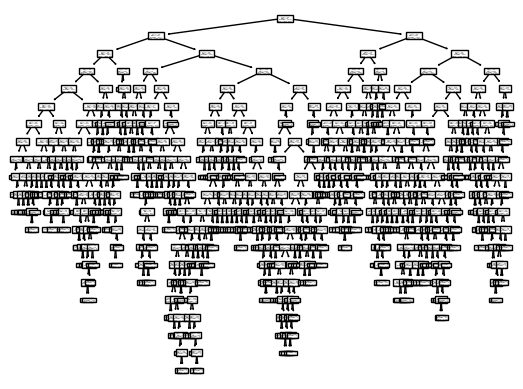

In [154]:
tree.plot_tree(dt_fit)

In [155]:
# Training the Logistic Regression model on the Training set
lr = LogisticRegression(random_state=10)
lr_fit = lr.fit(X_train, y_train)
# Predicting the Test set results
lr_predict = lr_fit.predict(X_test)

results_df.loc['Logistic Regression (Default)',:] = [f1_score(y_test,lr_predict, average='macro'), precision_score(y_test,lr_predict), recall_score(y_test,lr_predict),accuracy_score(y_test,lr_predict)]

results_df.sort_values(by='F-score', ascending=False)

,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.578521,0.635294,0.209845,0.742679
Logistic Regression (Default),0.539261,0.61828,0.148964,0.733529


In [156]:
solvers = ['lbfgs','newton-cg','liblinear','sag','saga']
penalty = ['l2', 'None']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iteration= [100, 200, 500, 1000, 2000, 5000]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values,max_iter=max_iteration)

lr_grid = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
lr_grid_fit = lr_grid.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(lr_grid.best_estimator_, X_train, y_train, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['Logistic Regression (Grid CV Tuning)',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score', ascending=False)


/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abdalrhm

,F-score,Precision,Recall,Accuracy
Logistic Regression (Grid CV Tuning),0.730179,0.739231,0.732153,0.733094
Decision Tree (Default),0.578521,0.635294,0.209845,0.742679
Logistic Regression (Default),0.539261,0.61828,0.148964,0.733529


In [157]:
randomForestModel=RandomForestClassifier(n_estimators=75)
randomForestModel.fit(X_train,y_train)
y_pred=randomForestModel.predict(X_test)

In [158]:
print('Accuracy Score: ',accuracy_score(y_test,y_pred))
print('Recall Score: ',recall_score(y_test,y_pred))
print('Jaccard Score: ',jaccard_score(y_test,y_pred))
print('F1 Score: ',f1_score(y_test,y_pred))
print('Precision Score: ',precision_score(y_test,y_pred))

plot = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),3), 
                template='simple_white',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
plot.update_xaxes(side="bottom")
plot.show()

Accuracy Score:  0.7408491947291361
Recall Score:  0.22927461139896374
Jaccard Score:  0.2
F1 Score:  0.3333333333333333
Precision Score:  0.6103448275862069


In [159]:
data = df.copy()
dataFrame=data.copy()
X = dataFrame.drop("is_delayed", axis=1)
y = dataFrame["is_delayed"]

# Encode categorical features
label_encoder = LabelEncoder()
X_encoded = X.apply(label_encoder.fit_transform)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.7, random_state=1)

# Initialize and fit the classifier
clf = RandomForestClassifier(random_state=70)
clf.fit(X_train, y_train)

# Predict on the test set
y_predict = clf.predict(X_test)

# Evaluate the model
print('Accuracy Score: ', accuracy_score(y_test, y_predict))
print('Recall Score: ', recall_score(y_test, y_predict))
print('Jaccard Score: ', jaccard_score(y_test, y_predict))
print('F1 Score: ', f1_score(y_test, y_predict))
print('Precision Score: ', precision_score(y_test, y_predict))

Accuracy Score:  0.8994614003590664
Recall Score:  0.8310897435897436
Jaccard Score:  0.7678412792419307
F1 Score:  0.8686767169179229
Precision Score:  0.9098245614035088


In [160]:
# create target variable for prediction
y = data['is_delayed']
y = np.array(y).astype(int)
x = data.drop(["is_delayed"], axis=1)

<AxesSubplot:>

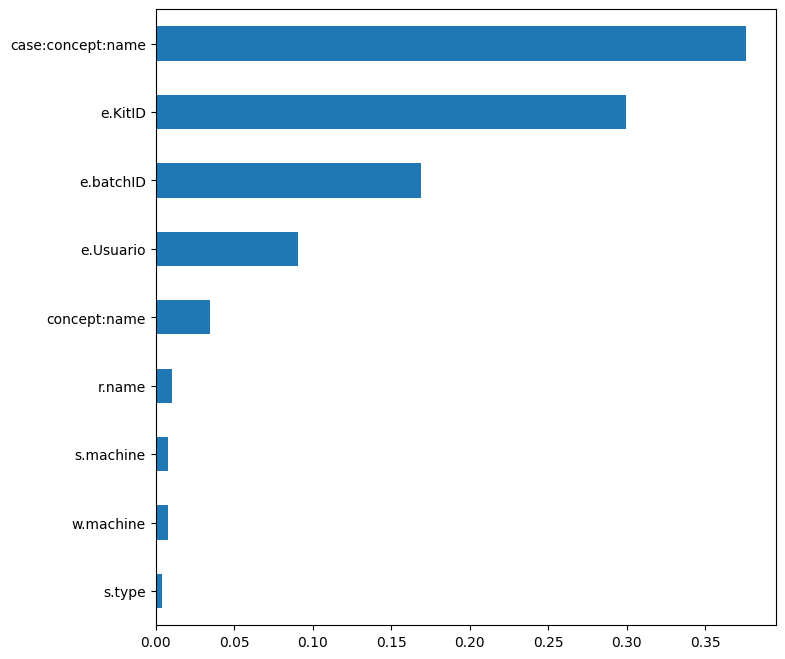

In [161]:
df_new = data.drop('is_delayed', axis=1)

var_imp = pd.DataFrame({'importance': clf.feature_importances_},
                       index=df_new.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

In [162]:
print(var_imp.sort_values(by='importance'))

                   importance
s.type               0.004146
w.machine            0.007605
s.machine            0.008213
r.name               0.010440
concept:name         0.034838
e.Usuario            0.090413
e.batchID            0.169190
e.KitID              0.299302
case:concept:name    0.375853


In [163]:
count = 0
accur = []
for i in clf.predict(X_test):
    if i == y[count]:
        accur.append(1)
    else:
        accur.append(0)
    count += 1

print(sum(accur) / len(accur))

0.5160297512182611


In [164]:
# Implementation of Random Forest Classifier
#clf = RandomForestClassifier(random_state=75)

# fit model with 5-fold Cross Validation
result = cross_validate(clf, X_train, y_train)  # (defaults) is 5-fold CV

In [165]:
# print evaluation metrics
print('fit_time:', result['fit_time'])
print('score_time:', result['score_time'])
print('test_score:', result['test_score'])
print('mean accuracy:', sum(result['test_score']) / len(result['test_score']))

fit_time: [0.99059772 1.1485858  0.93899608 0.96213722 0.95191312]
score_time: [0.04351521 0.04354715 0.04157686 0.04119182 0.04092169]
test_score: [0.89585051 0.88650728 0.87633965 0.89114898 0.89032435]
mean accuracy: 0.888034156270239
